# Training basic neural networks

In [16]:
### The function below calculates the number of parameters in a convolutional layer. 
### It takes as input the number of input channels, output channels, and kernel size, along with an optional trainable bias. 

In [18]:
def count_parameters_conv(in_channels: int, out_channels: int, kernel_size: int, bias: bool):
    if bias == True:
        b = 1
    else: 
        b = 0
    count_p = (in_channels * (kernel_size**2) + b) * out_channels
    return count_p

In [20]:
count_parameters_conv(3, 10, 3, True)

280

In [22]:
pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.


In [24]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from IPython.display import clear_output
from PIL import Image
from matplotlib import cm
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

# First model

In [28]:
### A fully connected neural network is trained for classification on the MNIST dataset, achieving 98% accuracy on the test set. 
### Previously defined train and evaluate functions can be used.
### To allow for model verification, a function named create_mlp_model is defined without arguments. 
### This function creates and returns the model object. 
### The model's weights are saved using torch.save and state_dict, ensuring they can be submitted for testing.

In [30]:
mnist_train = MNIST(
    "../datasets/mnist",
    train=True,
    download=True,
    transform=T.ToTensor()
)

### now we transformed image to tensor

In [32]:
mnist_valid = MNIST(
    "../datasets/mnist",
    train=False, ### validation
    download=True,
    transform=T.ToTensor()
)

In [34]:
len(mnist_train)

60000

In [36]:
len(mnist_valid)

10000

In [38]:
import sys
print("Python version:", sys.version)

Python version: 3.10.10 (main, Mar 21 2023, 13:41:05) [Clang 14.0.6 ]


In [40]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer

from typing import Tuple


def train(
    model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn
) -> Tuple[float, float]:
    model.train()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc='Train'):
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()

        optimizer.step()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total

In [42]:
@torch.inference_mode() ### switching off gradient calculation
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn) -> Tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc='Evaluate'):
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    return total_loss / len(data_loader), correct / total

In [44]:
def create_mlp_model():
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )
    return model

In [46]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
valid_loader = DataLoader(mnist_valid, batch_size=64, shuffle=False)

In [48]:
my_model = create_mlp_model()

In [50]:
optimizer = torch.optim.Adam(my_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

In [52]:
train(my_model, train_loader, optimizer, loss_fn)

Train: 100%|█████████████████████████████████| 938/938 [00:02<00:00, 394.28it/s]


(0.29777386405868633, 0.9175333333333333)

In [54]:
evaluate(my_model, valid_loader, loss_fn)

Evaluate: 100%|██████████████████████████████| 157/157 [00:00<00:00, 496.06it/s]


(0.15279257207349606, 0.9559)

In [60]:
from typing import List

def plot_stats(
    train_loss: List[float],
    valid_loss: List[float],
    valid_accuracy: List[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()

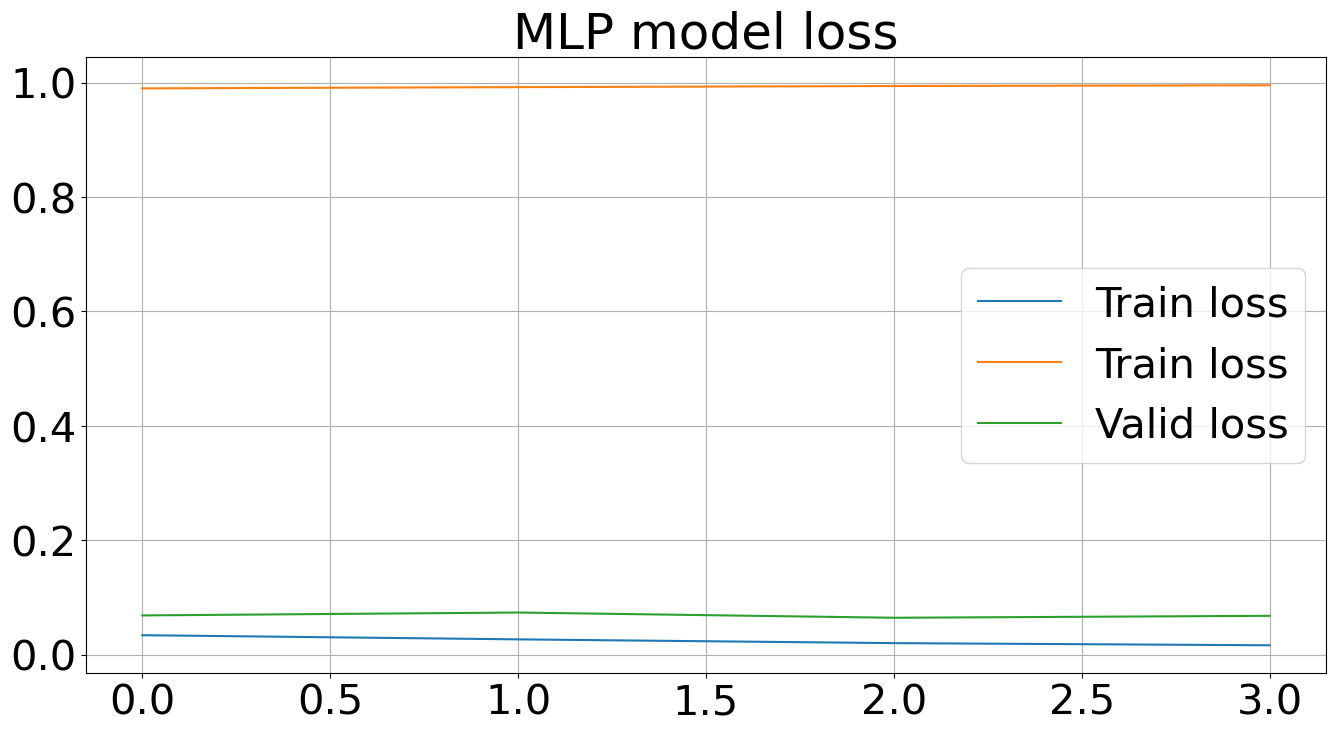

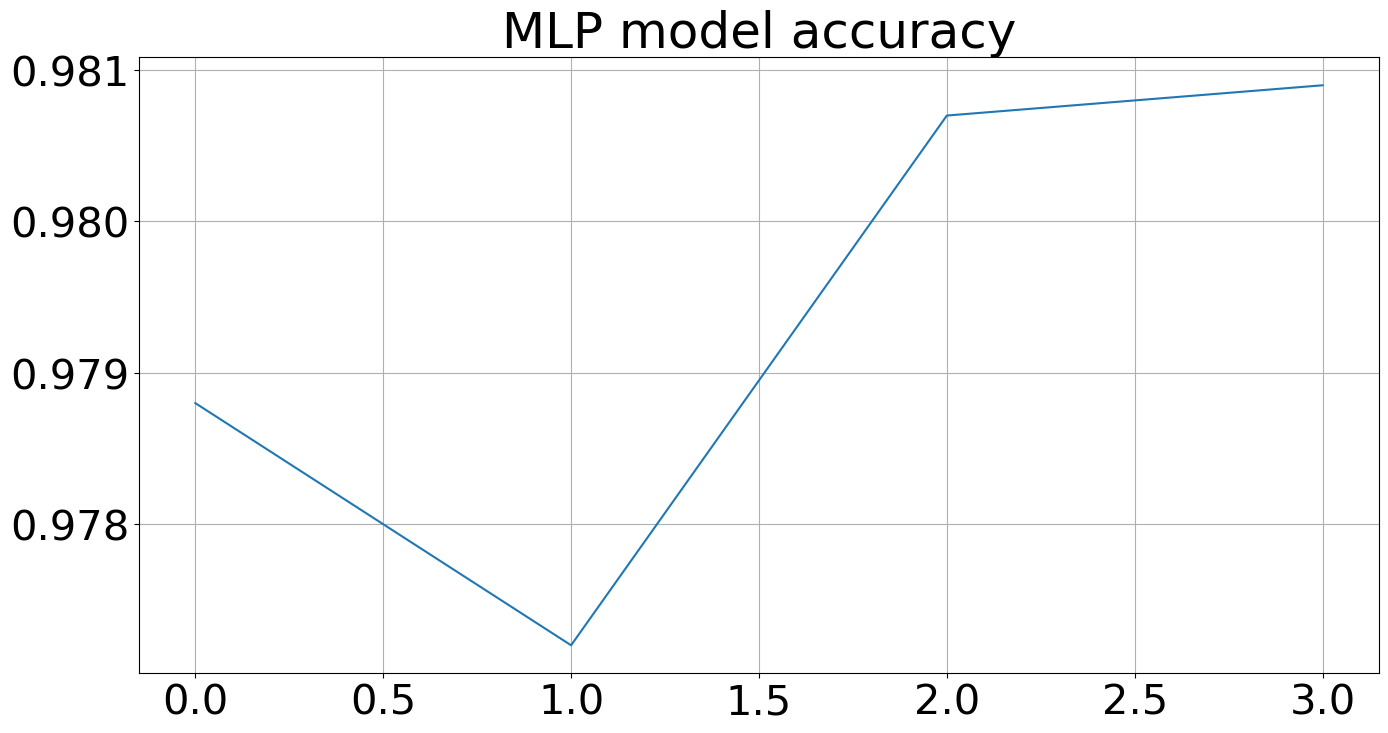

Total training and evaluation time 10.91131


In [62]:
num_epochs = 4

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(my_model, train_loader, optimizer, loss_fn)

    valid_loss, valid_accuracy = evaluate(my_model, valid_loader, loss_fn)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)
    
    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'MLP model')
    
print(f'Total training and evaluation time {perf_counter() - start:.5f}')

In [64]:
my_model.state_dict()

OrderedDict([('1.weight',
              tensor([[ 0.0300,  0.0237, -0.0294,  ...,  0.0052,  0.0323, -0.0025],
                      [ 0.0322,  0.0251, -0.0121,  ..., -0.0300, -0.0321,  0.0023],
                      [ 0.0103,  0.0211,  0.0060,  ..., -0.0273, -0.0256,  0.0302],
                      ...,
                      [-0.0020,  0.0227,  0.0348,  ..., -0.0180, -0.0284,  0.0318],
                      [ 0.0096, -0.0238, -0.0158,  ..., -0.0273, -0.0322, -0.0238],
                      [-0.0121, -0.0012, -0.0252,  ..., -0.0156,  0.0211, -0.0024]])),
             ('1.bias',
              tensor([ 8.9548e-02,  1.7732e-01, -1.4232e-01, -6.7338e-02,  7.7047e-02,
                       1.9511e-02, -5.1733e-02,  2.3263e-01,  1.4705e-01,  4.9545e-02,
                       7.5179e-02, -3.5887e-02, -5.8941e-02,  5.0030e-02,  1.1316e-01,
                      -4.9954e-02, -9.4587e-02,  7.6424e-02, -2.3510e-02, -1.4082e-01,
                      -4.4023e-02,  2.2433e-02,  1.0384e-01, -4.2120

In [66]:
torch.save(my_model.state_dict(), "model_weights.pth")

# Second model

In [ ]:
### A convolutional neural network is trained for classification on the MNIST dataset, achieving 99.3% accuracy on the test set. 
### Previously implemented train and evaluate functions a be used.

To enable model verification, a function named create_conv_model is defined without arguments. This function creates and returns the model object. The model's weights are saved using torch.save and state_dict, ensuring they can be submitted for testing.

In [29]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer

from typing import Tuple


def create_conv_model():
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(4 * 4 * 64, 256), ### 64 channels
        nn.ReLU(),
        nn.Linear(256, 10)
    )
    return model


second_model = create_conv_model()

optimizer = torch.optim.Adam(second_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

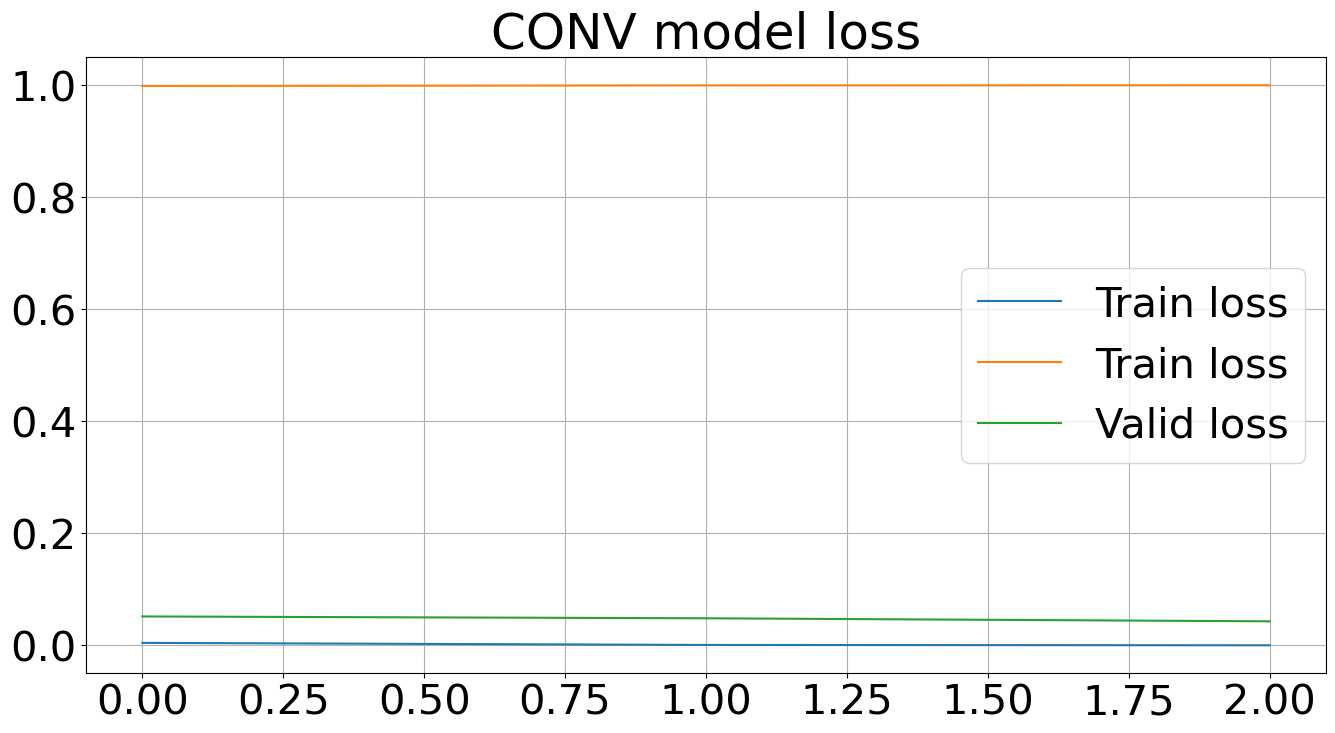

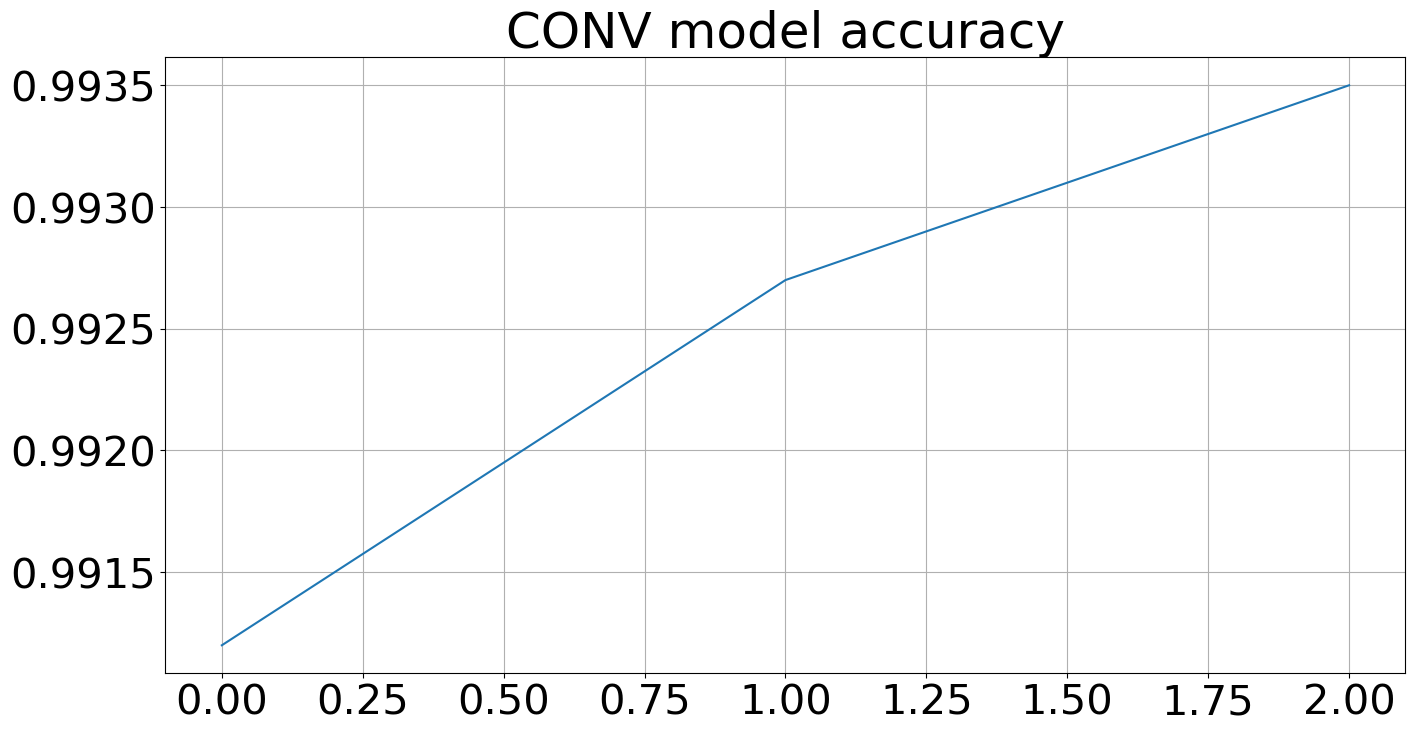

Total training and evaluation time 58.35706


In [39]:
num_epochs = 3

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(second_model, train_loader, optimizer, loss_fn)

    valid_loss, valid_accuracy = evaluate(second_model, valid_loader, loss_fn)
    
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'CONV model')

print(f'Total training and evaluation time {perf_counter() - start:.5f}')

In [41]:
torch.save(second_model.state_dict(), "model_weights_2.pth")

In [43]:
second_model.state_dict()

OrderedDict([('0.weight',
              tensor([[[[ 9.4367e-02,  7.9825e-02, -1.1852e-01, -1.0217e-01,  3.3776e-01],
                        [ 3.2796e-02,  1.0709e-01, -8.8551e-02, -3.1435e-01,  1.6073e-01],
                        [ 7.8758e-02, -1.8136e-02,  2.1593e-01, -1.2452e-01, -4.4695e-02],
                        [ 7.3277e-02,  1.3800e-01, -2.3828e-01, -3.6804e-01, -1.7023e-01],
                        [-2.5132e-01,  1.2538e-01,  8.7737e-02, -4.4037e-02, -4.6971e-02]]],
              
              
                      [[[ 2.4235e-02,  5.3593e-03,  2.6064e-01,  2.1160e-01,  3.2672e-01],
                        [-1.7424e-01, -4.0927e-01, -2.6156e-01,  7.6930e-02,  1.5495e-01],
                        [ 7.7492e-02, -4.5599e-01, -6.8256e-01, -5.0531e-01, -1.2978e-01],
                        [ 2.9460e-01,  3.2000e-01,  6.4459e-02, -2.3806e-01, -1.4117e-01],
                        [ 2.7361e-01,  1.1719e-01,  1.5429e-01,  2.3067e-01, -6.1445e-02]]],
              
              
